In [ ]:
import os
#to read image
from skimage.io import imread
#to resize image to uniform sizes
from skimage.transform import resize
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

import cv2
import seaborn as sns
import tensorflow.keras.backend as K
from sklearn.preprocessing import label_binarize

import keras
from keras.models import Model
from tensorflow.keras.utils import load_img, img_to_array
from keras.layers import Dense, Flatten,Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator #, load_img, img_to_array #

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,auc,precision_score, recall_score,accuracy_score,f1_score,classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = ("/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
valid_dir = os.path.join(data_dir, "val")

In [ ]:
#Category name based on subclasses directory in dataset
CATEGORIES =["glioma", "meningioma", "pituitary"]
NUM_OF_CATEGORIES = len(CATEGORIES)
NUM_OF_CATEGORIES

3

In [ ]:
# Data Information

def data_information(sub_data_dir):
    for category in CATEGORIES:
        print('{} {} images'.format(category,len(os.listdir(os.path.join(sub_data_dir, category)))))

print("\n Training Dataset: \n")
data_information(train_dir)
print("\n Testing Dataset: \n")
data_information(test_dir)
print("\n Validation Dataset: \n")
data_information(valid_dir)


 Training Dataset: 

glioma 855 images
meningioma 424 images
pituitary 566 images

 Testing Dataset: 

glioma 286 images
meningioma 143 images
pituitary 191 images

 Validation Dataset: 

glioma 285 images
meningioma 141 images
pituitary 186 images


In [ ]:
def data_preparation(data, subpath_dir, dataset_dir):
    data_list = []  # Use a different variable name to store collected information
    #tumor category
    for category_id, category in enumerate(CATEGORIES):
        #main_directory + category
        category_dir = os.path.join(dataset_dir, category)

        for file in os.listdir(category_dir):
            data_list.append([f'{data_dir}/{subpath_dir}/{category}/{file}', category_id, category])

    data = pd.DataFrame(data_list, columns=['file', 'category_id', 'category'])
    print(f'Shape of {subpath_dir} dataset: {data.shape}')
    return data

train = pd.DataFrame()
trainset = data_preparation(train, 'Training', train_dir)
trainset.head(2)

Shape of Training dataset: (1845, 3)


file  category_id category
0  /content/drive/MyDrive/Brain_tumor_classificat...            0   glioma
1  /content/drive/MyDrive/Brain_tumor_classificat...            0   glioma

In [ ]:
test = pd.DataFrame()
testset = data_preparation(test, 'Testing', test_dir)
valid = pd.DataFrame()
validset = data_preparation(valid, 'Validation', valid_dir)

Shape of Testing dataset: (620, 3)
Shape of Validation dataset: (612, 3)


In [ ]:
trainset['category'].value_counts()

category
glioma        855
pituitary     566
meningioma    424
Name: count, dtype: int64

# **Exploratory Data Analysis**

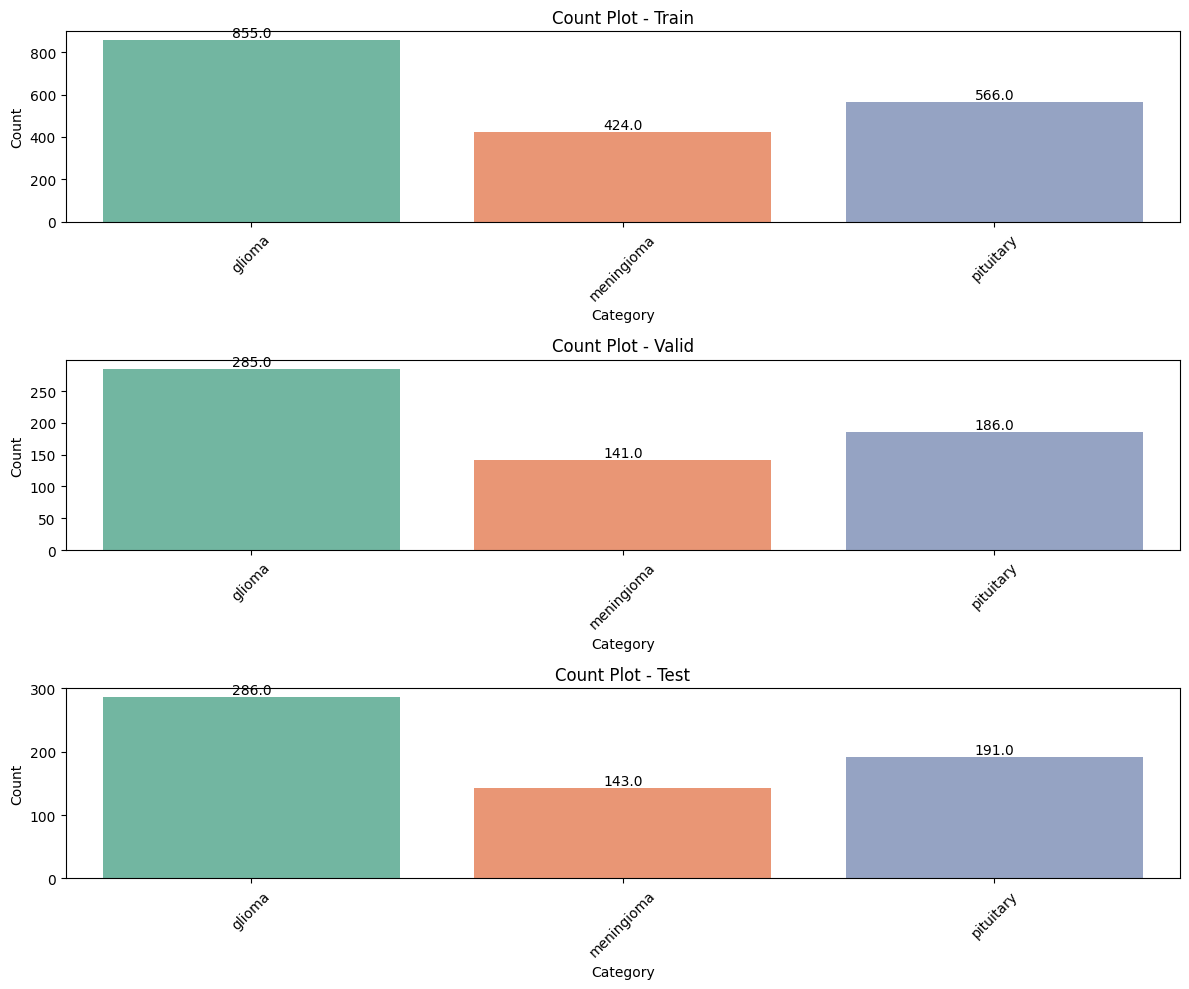

In [ ]:

CATEGORIES = ["glioma", "meningioma", "pituitary"]

# Define a function to create subplots with count plots for different categories
def plot_countplots(train, valid, test, categories):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))  # Create a 3x1 subplot layout

    datasets = [train, valid, test]
    dataset_names = ['Train', 'Valid', 'Test']

    for i, ax in enumerate(axes.flatten()):
        # Assign 'category' to 'hue' and set 'legend' to False
        sns.countplot(data=datasets[i], x='category', hue='category', ax=ax, palette="Set2", legend=False)
        ax.set_title(f'Count Plot - {dataset_names[i]}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Count')

        # Rotate x-tick labels (FIX HERE)
        ax.set_xticks(ax.get_xticks()) # Explicitly set the xtick positions
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Get the xticklabels and rotate them

        # Add annotations (counts) on top of each bar
        for p in ax.patches:
            ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()  # Adjust layout for better presentation
    plt.show()

# Example usage
# Assuming trainset, validset, and testset are your DataFrames
plot_countplots(trainset, validset, testset, CATEGORIES)

In [ ]:
#category sampling
SAMPLE_PER_CATEGORIES = 1321
#reproducability
SEED =42
#image re-sizing
WIDTH = 150
HEIGHT =150
#No of channels
DEPTH = 3

INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

In [ ]:
training = trainset.copy()
training = pd.concat([training[training['category']==c][:SAMPLE_PER_CATEGORIES] for c in CATEGORIES])
training = training.sample(frac=1)
training.index = np.arange(len(training))
training.shape
validing = validset.copy()
testing = testset.copy()

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

def read_img(filepath, size):
    # Use load_img and img_to_array directly from tensorflow.keras.utils
    img = load_img(filepath, target_size=size)
    img = img_to_array(img)
    return img

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size
img_size = (256,256)

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load training data with augmentation
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/train',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Load validation data without augmentation
val_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/val',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Load test data without augmentation
test_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/test',
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1845 images belonging to 3 classes.
Found 612 images belonging to 3 classes.
Found 620 images belonging to 3 classes.


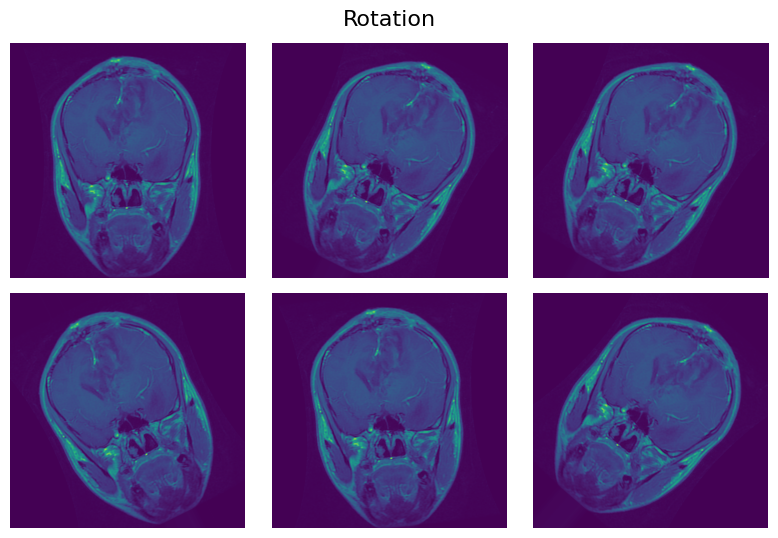

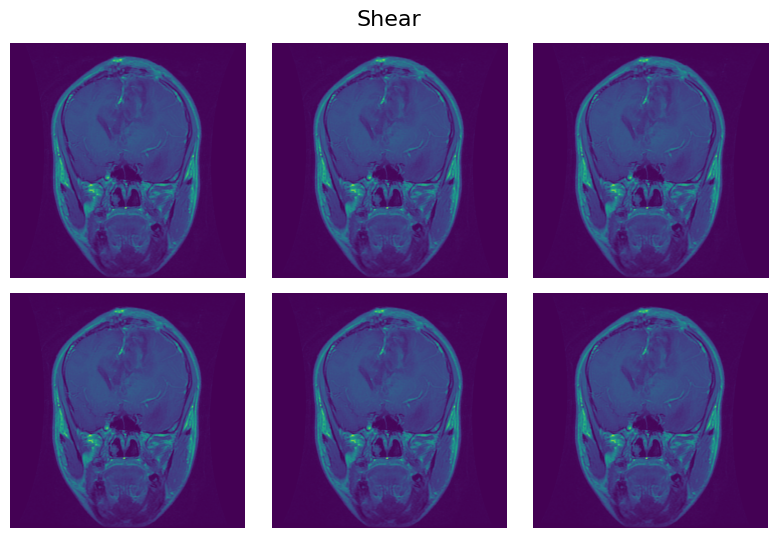

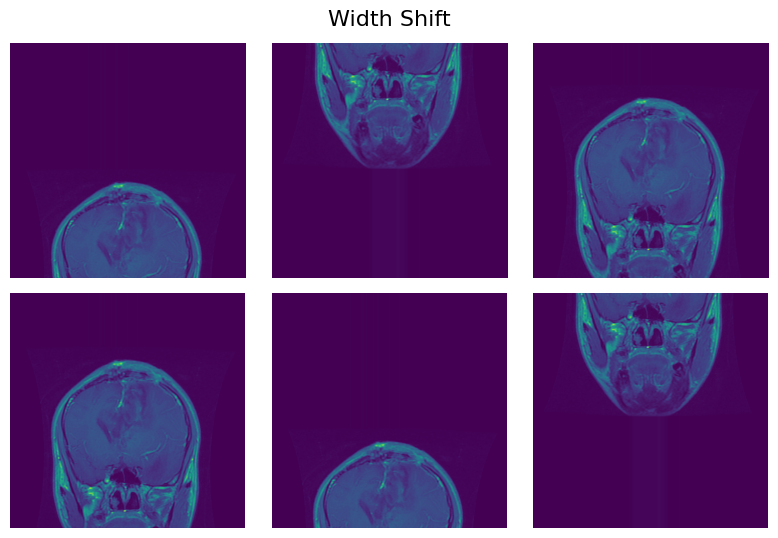

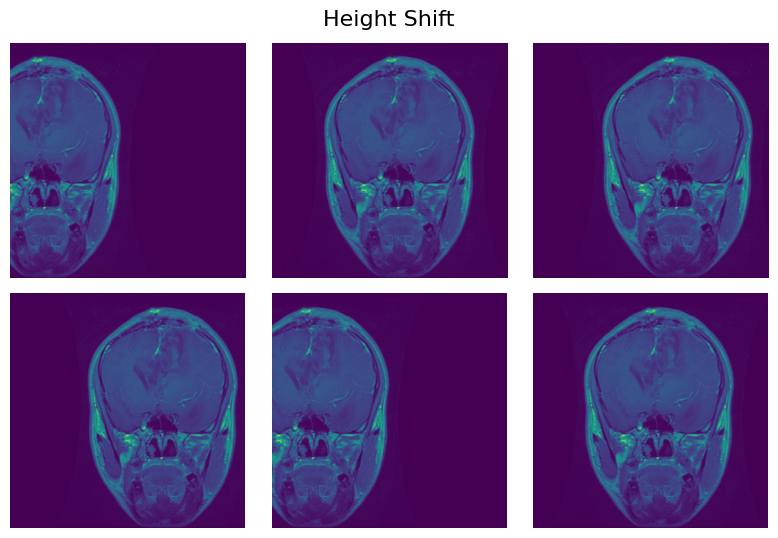

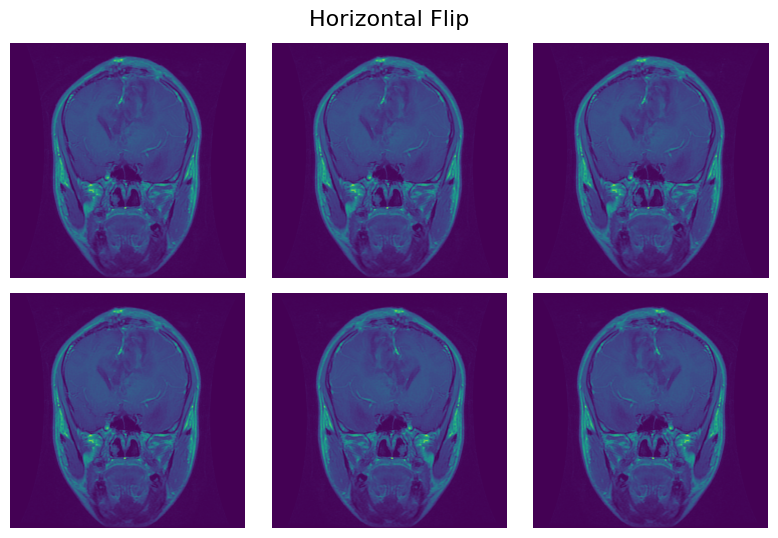

In [ ]:
# Path to the image you want to augment
image_path = '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/train/glioma/10.png'  # Replace with the actual path to your image

# Load the image
img = load_img(image_path)
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

# Define ImageDataGenerators with different augmentation settings
datagen_rotation = ImageDataGenerator(rotation_range=45)
datagen_width_shift = ImageDataGenerator(width_shift_range=0.6)
datagen_height_shift = ImageDataGenerator(height_shift_range=0.4)
datagen_shear = ImageDataGenerator(shear_range=2)
datagen_flip = ImageDataGenerator(horizontal_flip=True)

data_generators = [datagen_rotation, datagen_shear, datagen_width_shift, datagen_height_shift, datagen_flip]
attributes = ['Rotation', 'Shear', 'Width Shift', 'Height Shift',  'Horizontal Flip']

for i, datagen in enumerate(data_generators):
    augmented_images = []
    plt.figure(figsize=(8, 8))
    plt.suptitle(attributes[i], fontsize=16)

    generator = datagen.flow(img_array, batch_size=1)
    for j in range(6):
        batch = next(generator)
        augmented_images.append(batch[0].astype('uint8'))
        plt.subplot(3, 3, j + 1)
        plt.imshow(batch[0].astype('uint8'))
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# **InceptionV3 Architecture**

In [ ]:
from tensorflow.keras.applications import InceptionV3
# Load InceptionV3 with pretrained weights, excluding the top layer
base_model = InceptionV3(weights='imagenet', include_top=False,classes=1000, input_shape=(256, 256, 3))

# Freeze initial layers for feature extraction
for layer in base_model.layers:
    layer.trainable = True

# Custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()
# Path to save the best model

checkpoint_path = "/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/L_INCEPTION_model.keras"



# ModelCheckpoint to save the model with the lowest validation loss
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
# Early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr=ReduceLROnPlateau(monitor="val_accuracy",
                           factor=0.3,
                           patience=2,verbose=1,
                           mode="auto")

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 127, 127, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 127, 127, 32)   │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 127, 127, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 125, 125, 32)   │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 125, 125, 32)   │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 125, 125, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 125, 125, 64)   │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 125, 125, 64)   │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 62, 62, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 62, 62, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 62, 62, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 23,904,035 (91.19 MB)

 Trainable params: 23,869,603 (91.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Train the model with validation data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6127 - loss: 0.8532
Epoch 1: val_accuracy improved from -inf to 0.52632, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/L_INCEPTION_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.6146 - loss: 0.8495 - val_accuracy: 0.5263 - val_loss: 1.9291 - learning_rate: 1.0000e-04
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 24s 432ms/step - accuracy: 0.8750 - loss: 0.3488
Epoch 2: val_accuracy improved from 0.52632 to 0.75000, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/L_INCEPTION_model.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 583ms/step - accuracy: 0.8750 - loss: 0.3488 - val_accuracy: 0.7500 - val_loss: 0.6319 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 960ms/step - accuracy: 0.8913 - loss: 0.2873
Epoch 3: val_accuracy did not improve from 0.75000
57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8914 - loss: 0.2871 - val_a

## **training and validation accuracy and loss**

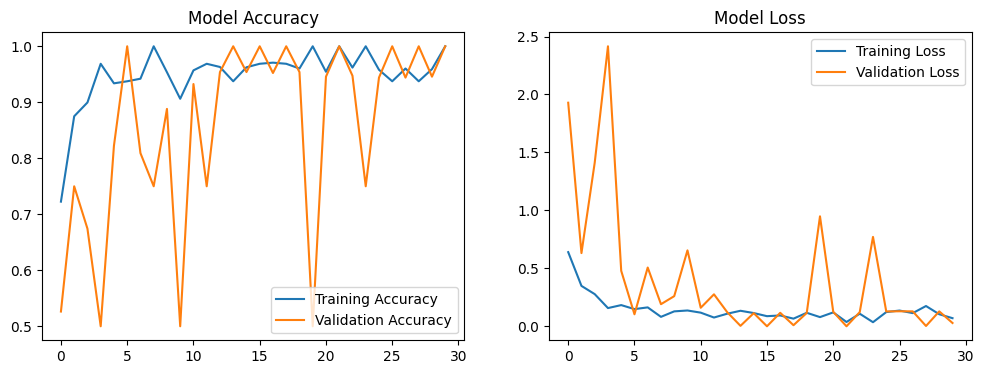

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
inception_model = load_model('/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/L_INCEPTION_model.keras')

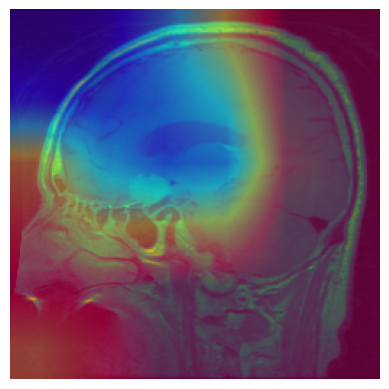

In [ ]:
# Grad-CAM for explainability
def get_gradcam_heatmap(model, img_array, layer_name='mixed10'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Load an example MRI image
img_path = '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/test/pituitary/1017.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Generate and display Grad-CAM heatmap
heatmap = get_gradcam_heatmap(inception_model, img_array, layer_name='conv2d_375')
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


In [ ]:
test_loss1, test_accuracy1 = inception_model.evaluate(test_generator)
print("Inception /n Test Loss:", test_loss1)
print("Test Accuracy:", test_accuracy1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 245s 12s/step - accuracy: 0.8089 - loss: 0.5182
Inception /n Test Loss: 0.5337944030761719
Test Accuracy: 0.8129032254219055


In [ ]:
# test_loss1, test_accuracy1 = model.evaluate(test_generator)
# print("Inception /n Test Loss:", test_loss1)
# print("Test Accuracy:", test_accuracy1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 252s 13s/step - accuracy: 0.9602 - loss: 0.0952
Inception /n Test Loss: 0.10277175158262253
Test Accuracy: 0.9629032015800476


## **Evaluation Metrics**

Generating predictions from test data...
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step
Confusion Matrix:
 [[283   3   0]
 [ 27 113   3]
 [ 44  39 108]] 

Accuracy: 0.8129032258064516
Overall Precision: 0.8338134197620256
Overall Recall: 0.7817217686327633
Overall f1_score: 0.7859986832748121
Classification Report:
               precision    recall  f1-score   support

      glioma       0.80      0.99      0.88       286
  meningioma       0.73      0.79      0.76       143
   pituitary       0.97      0.57      0.72       191

    accuracy                           0.81       620
   macro avg       0.83      0.78      0.79       620
weighted avg       0.84      0.81      0.80       620



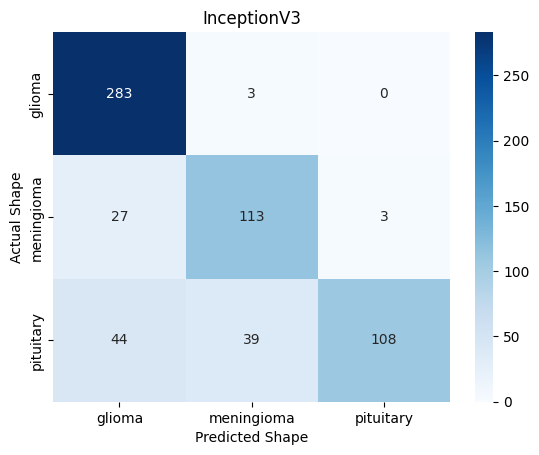

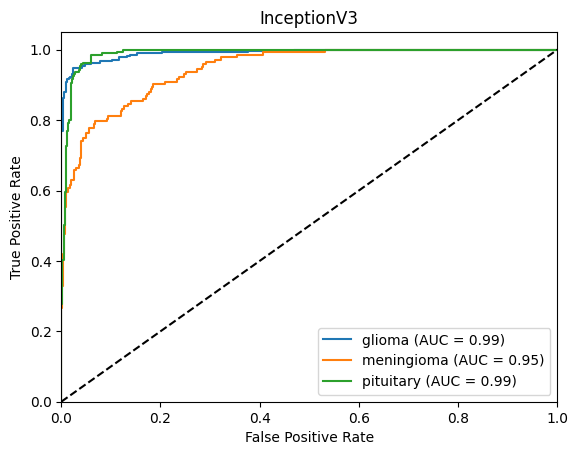

In [ ]:
%matplotlib inline

print("Generating predictions from test data...")
# # Get the image and label arrays for the first batch of validation data
# x_test = test_generator[0][0]
# y_test = test_generator[0][1]

# # Use the model to predict the class
# class_probabilities1 = model.predict(x_test)

# prediction on the whole test dataset
class_probabilities1 = inception_model.predict(test_generator)

# Get true labels from the test generator
true_labels = test_generator.classes

classnames = ['glioma', 'meningioma', 'pituitary']

# # The model returns a probability value for each class
# # The one with the highest probability is the predicted class
# predictions = np.argmax(class_probabilities1, axis=1)

# Convert predictions from probabilities to class labels
predictions = class_probabilities1.argmax(axis=1)


# # The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
# true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)

print('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(true_labels, predictions))
print("Overall Precision:",precision_score(true_labels, predictions,  average='macro'))
print("Overall Recall:",recall_score(true_labels, predictions, average='macro'))
print("Overall f1_score:",f1_score(true_labels, predictions, average='macro'))
print("Classification Report:\n",classification_report(true_labels, predictions, target_names=classnames))


# plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues')


# plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks+0.5, classnames)#, rotation=85)
plt.yticks(tick_marks+0.5, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.title('InceptionV3')
plt.show()


# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels, class_probabilities1[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='{0} (AUC = {1:.2f})'.format(['glioma', 'meningioma', 'pituitary'][i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('InceptionV3')
plt.legend(loc='lower right')
plt.show()


In [ ]:
class_probabilities1.shape

(620, 3)

# **ResNet50 Architecture**

In [ ]:
def train(train_generator, val_generator, model_path,arc):


    # Load architecture with pretrained weights, excluding the top layer
    base_model = arc(weights='imagenet', include_top=False,classes=1000, input_shape=(256, 256, 3))

    # Fine-tune the last layers
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top of architcture
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # ModelCheckpoint and EarlyStopping
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    reduce_lr=ReduceLROnPlateau(monitor="val_accuracy",
                           factor=0.3,
                           patience=2,verbose=1,
                           mode="auto")

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        epochs=30,
        callbacks=[reduce_lr, checkpoint]
    )

    return model, history


In [ ]:
# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Model Loss')
    plt.show()


In [ ]:
# Grad-CAM for explainability
def get_gradcam_heatmap(model, img_array, layer_name='mixed10'):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap



In [ ]:
%matplotlib inline

def evaluate_model(model, model_name):
  # prediction on the whole test dataset
  class_probabilities = model.predict(test_generator)

  # Get true labels from the test generator
  true_labels = test_generator.classes

  classnames = ['glioma', 'meningioma', 'pituitary']

  # Convert predictions from probabilities to class labels
  predictions = class_probabilities.argmax(axis=1)

  # Plot the confusion matrix
  cm = confusion_matrix(true_labels, predictions)

  print('Confusion Matrix:\n',cm, '\n')
  print('Accuracy:', accuracy_score(true_labels, predictions))
  print("Overall Precision:",precision_score(true_labels, predictions,  average='macro'))
  print("Overall Recall:",recall_score(true_labels, predictions, average='macro'))
  print("Overall f1_score:",f1_score(true_labels, predictions, average='macro'))
  print("Classification Report:\n",classification_report(true_labels, predictions, target_names=classnames))

  # plot confusion matrix with seaborn
  sns.heatmap(cm, annot=True, fmt='.3g', cmap='Blues')

  tick_marks = np.arange(len(classnames))
  plt.xticks(tick_marks+0.5, classnames)
  plt.yticks(tick_marks+0.5, classnames)
  plt.xlabel("Predicted Shape")
  plt.ylabel("Actual Shape")
  plt.title(f'{model_name}')
  plt.show()

  # Plot ROC curve
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(true_labels, class_probabilities[:, i], pos_label=i)
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  for i in range(3):
      plt.plot(fpr[i], tpr[i], label='{0} (AUC = {1:.2f})'.format(['glioma', 'meningioma', 'pituitary'][i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim(0.0, 1.0)
  plt.ylim(0.0, 1.05)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{model_name}')
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
# Specify unique paths for each model
resnet_model_path = '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/m_RESNET50.keras'

# Train ResNet50 model
resnet_model, resnet_history = train(train_generator, val_generator, resnet_model_path,ResNet50)


Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6861 - loss: 0.7386
Epoch 1: val_accuracy improved from -inf to 0.46711, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/m_RESNET50.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 459s 6s/step - accuracy: 0.6881 - loss: 0.7343 - val_accuracy: 0.4671 - val_loss: 1.6605 - learning_rate: 1.0000e-04
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 22s 395ms/step - accuracy: 0.8750 - loss: 0.2871

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.46711
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8750 - loss: 0.2871 - val_accuracy: 0.2500 - val_loss: 1.7073 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.9037 - loss: 0.2424
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 3: val_accuracy did not improve from 0.46711
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9038 - loss: 0.2423 - val_accuracy: 0.2286 - val_loss: 1.2790 - learning_rate: 1.0000e-04
Epoch 4/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 19s 349ms/step - accuracy: 0.9375 - loss: 0.1533
Epoch 4: val_accuracy did not improve from 0.46711
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.9375 - loss: 0.1533 - val_accuracy: 0.2500 - val_loss: 1.2048 - learning_rate: 3.0000e-05
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.9496 - loss: 0.1318
Epoch 5: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.


## **training and validation accuracy and loss**

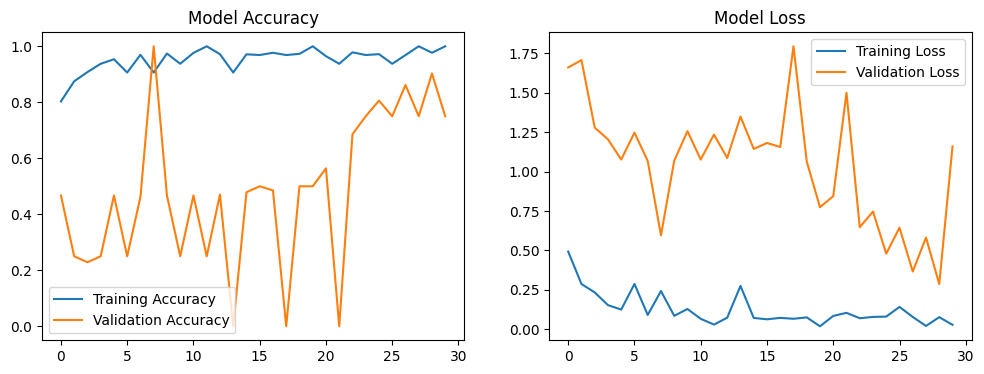

In [ ]:
plot_history(resnet_history)

In [ ]:
from keras.models import load_model
resnet_model = load_model('/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/m_RESNET50.keras')

In [ ]:
test_loss2, test_accuracy2 = resnet_model.evaluate(test_generator)
print("ResNet50 /n Test Loss:", test_loss2)
print("Test Accuracy:", test_accuracy2)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - accuracy: 0.4598 - loss: 1.0681
ResNet50 /n Test Loss: 1.064650297164917
Test Accuracy: 0.4612903296947479


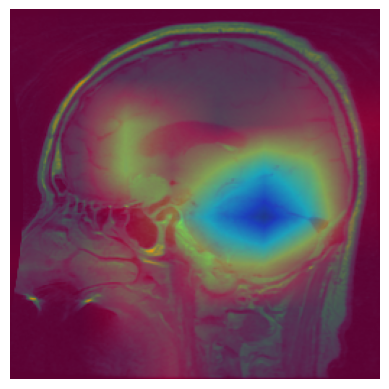

In [ ]:
# Generate Grad-CAM for ResNet50 with specific layer
heatmap = get_gradcam_heatmap(resnet_model, img_array, layer_name='conv5_block3_out')
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


## **Evaluation Metrics**

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 466ms/step
Confusion Matrix:
 [[286   0   0]
 [143   0   0]
 [191   0   0]] 

Accuracy: 0.4612903225806452
Overall Precision: 0.15376344086021507
Overall Recall: 0.3333333333333333
Overall f1_score: 0.21044885945548197
Classification Report:
               precision    recall  f1-score   support

      glioma       0.46      1.00      0.63       286
  meningioma       0.00      0.00      0.00       143
   pituitary       0.00      0.00      0.00       191

    accuracy                           0.46       620
   macro avg       0.15      0.33      0.21       620
weighted avg       0.21      0.46      0.29       620



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

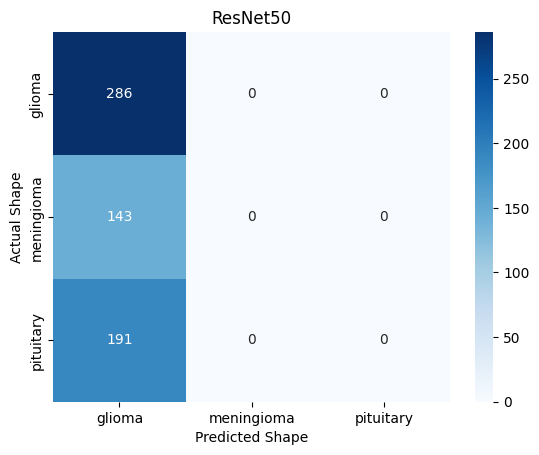

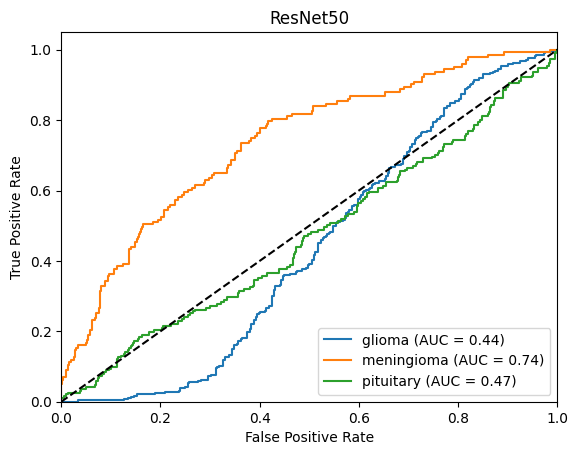

In [ ]:
evaluate_model(resnet_model, 'ResNet50')

# **VGG16 Architecture**

In [ ]:
from tensorflow.keras.applications import VGG16
# Specify unique path for VGG16 model
vgg16_model_path = '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/v_VGG16.keras'

# Train VGG16 model
vgg16_model, vgg16_history = train(train_generator, val_generator, vgg16_model_path,VGG16)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4282 - loss: 1.0945
Epoch 1: val_accuracy improved from -inf to 0.67763, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/v_VGG16.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.4290 - loss: 1.0936 - val_accuracy: 0.6776 - val_loss: 0.8538 - learning_rate: 1.0000e-04
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 36s 656ms/step - accuracy: 0.6562 - loss: 0.8190

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.67763 to 0.75000, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/v_VGG16.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.6562 - loss: 0.8190 - val_accuracy: 0.7500 - val_loss: 0.7890 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5845 - loss: 0.9005
Epoch 3: val_accuracy improved from 0.75000 to 0.78289, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/v_VGG16.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.5847 - loss: 0.8998 - val_accuracy: 0.7829 - val_loss: 0.6114 - learning_rate: 1.0000e-04
Epoch 4/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 35s 627ms/step - accuracy: 0.6250 - loss: 0.6807
Epoch 4: val_accuracy improved from 0.78289 to 1.00000, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/v_VGG16.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - accuracy: 0.6250 - loss: 0.6807 - va

## **training and validation accuracy and loss**

In [ ]:
vgg16_model = load_model('/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/v_VGG16.keras')

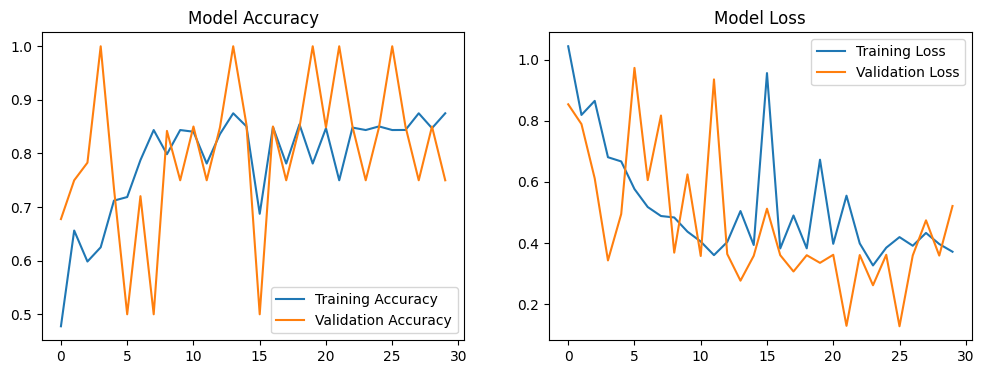

In [ ]:
plot_history(vgg16_history)

In [ ]:
test_loss3, test_accuracy3 = vgg16_model.evaluate(test_generator)
print("VGG16 /n Test Loss:", test_loss3)
print("Test Accuracy:", test_accuracy3)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - accuracy: 0.7826 - loss: 0.5852
VGG16 /n Test Loss: 0.5765635371208191
Test Accuracy: 0.7822580933570862


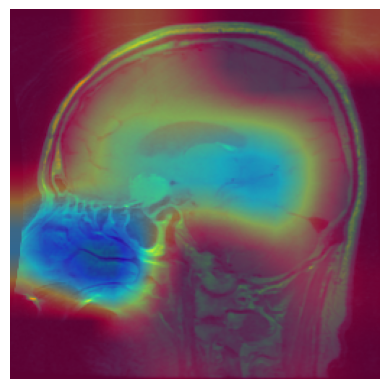

In [ ]:

# Generate Grad-CAM for vgg16 with specific layer
heatmap = get_gradcam_heatmap(vgg16_model, img_array, layer_name='block5_conv3')
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


## **Evaluation Metrics**

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 542ms/step
Confusion Matrix:
 [[203  78   5]
 [  3  97  43]
 [  1   5 185]] 

Accuracy: 0.782258064516129
Overall Precision: 0.7711855445667725
Overall Recall: 0.7855660918488144
Overall f1_score: 0.765596705415036
Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.71      0.82       286
  meningioma       0.54      0.68      0.60       143
   pituitary       0.79      0.97      0.87       191

    accuracy                           0.78       620
   macro avg       0.77      0.79      0.77       620
weighted avg       0.82      0.78      0.79       620



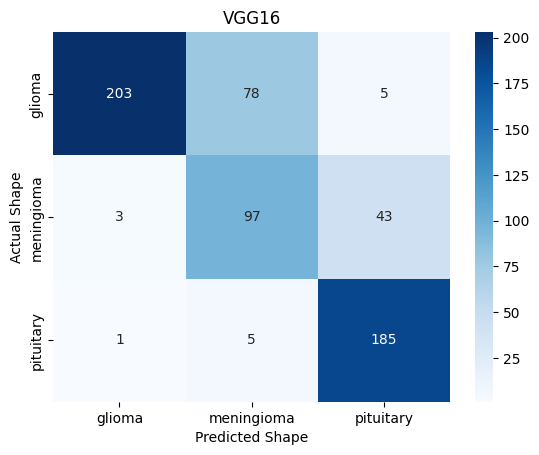

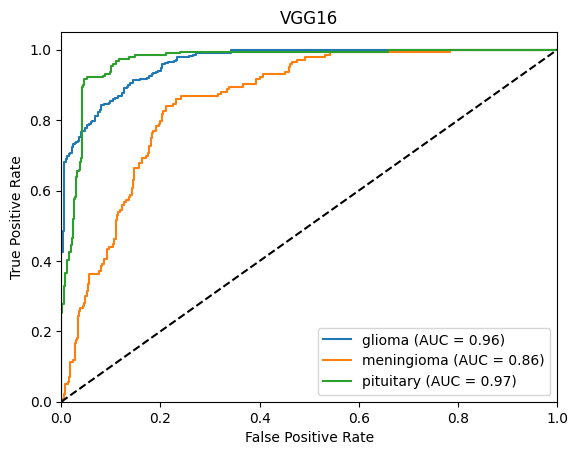

In [ ]:
evaluate_model(vgg16_model, 'VGG16')

# **InceptionResNetV2 Architecture**

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

# Specify unique path for InceptionResNetV2 model
InceptionResNetV2_model_path = '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/InceptionResNetV2.keras'

# Train InceptionResNetV2 model
InceptionResNetV2_model, InceptionResNetV2_history = train(train_generator, val_generator, InceptionResNetV2_model_path,InceptionResNetV2)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.6167 - loss: 0.7812 
Epoch 1: val_accuracy improved from -inf to 0.66283, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/InceptionResNetV2.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 2293s 33s/step - accuracy: 0.6190 - loss: 0.7774 - val_accuracy: 0.6628 - val_loss: 1.4048 - learning_rate: 1.0000e-04
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 42s 754ms/step - accuracy: 0.9062 - loss: 0.2882

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.66283
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.9062 - loss: 0.2882 - val_accuracy: 0.2500 - val_loss: 2.3125 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9264 - loss: 0.2136
Epoch 3: val_accuracy improved from 0.66283 to 0.92599, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/InceptionResNetV2.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9264 - loss: 0.2133 - val_accuracy: 0.9260 - val_loss: 0.2054 - learning_rate: 1.0000e-04
Epoch 4/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 42s 757ms/step - accuracy: 0.9062 - loss: 0.2616
Epoch 4: val_accuracy improved from 0.92599 to 1.00000, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/InceptionResNetV2.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step - accuracy: 0.9062 - loss: 0.2616 - val_accuracy: 1.0000 - val_loss: 0.0420 - learning_rate: 1.0000e-04
Epoch 5/30
57/57

## **training and validation accuracy and loss**

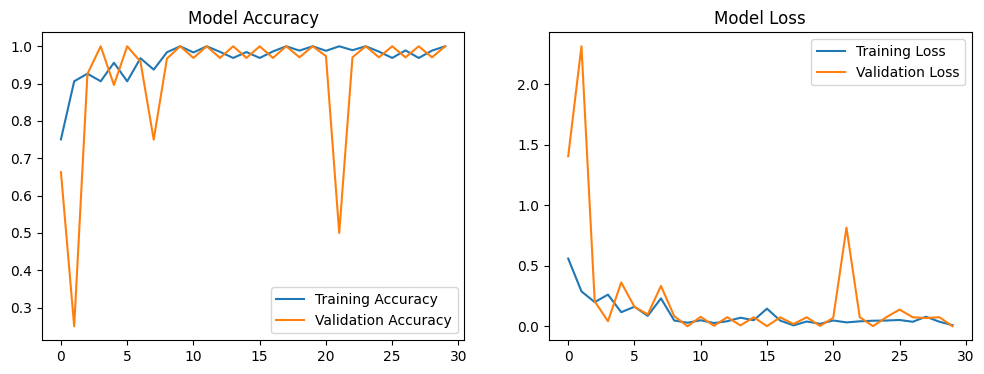

In [ ]:
plot_history(InceptionResNetV2_history)

In [ ]:
InceptionResnet_model = load_model('/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/InceptionResNetV2.keras')

test_loss4, test_accuracy4 = InceptionResnet_model.evaluate(test_generator)
print("InceptionResNetV2 /n Test Loss:", test_loss4)
print("Test Accuracy:", test_accuracy4)

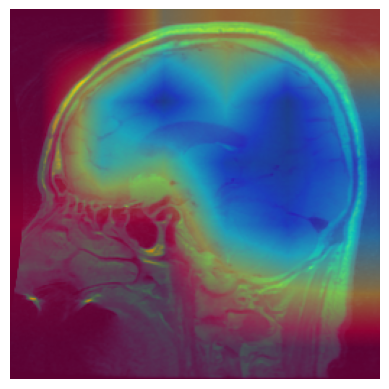

In [ ]:
# Generate Grad-CAM for ResNet50 with specific layer
heatmap = get_gradcam_heatmap(InceptionResNetV2_model, img_array, layer_name='conv_7b')
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


## **Evaluation Metrics**

20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 688ms/step
Confusion Matrix:
 [[284   2   0]
 [ 18 116   9]
 [ 11   1 179]] 

Accuracy: 0.9338709677419355
Overall Precision: 0.9447552727841186
Overall Recall: 0.9137895263549715
Overall f1_score: 0.9261114302313201
Classification Report:
               precision    recall  f1-score   support

      glioma       0.91      0.99      0.95       286
  meningioma       0.97      0.81      0.89       143
   pituitary       0.95      0.94      0.94       191

    accuracy                           0.93       620
   macro avg       0.94      0.91      0.93       620
weighted avg       0.94      0.93      0.93       620



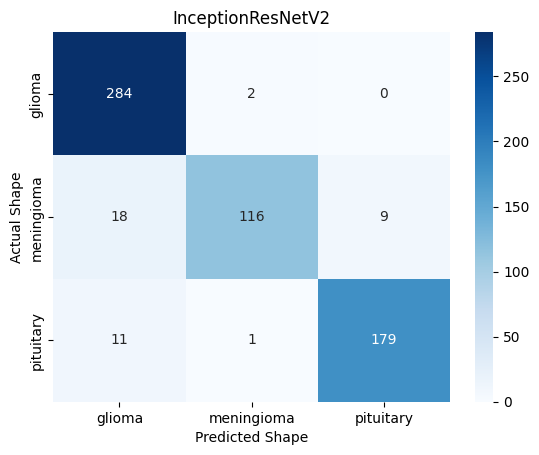

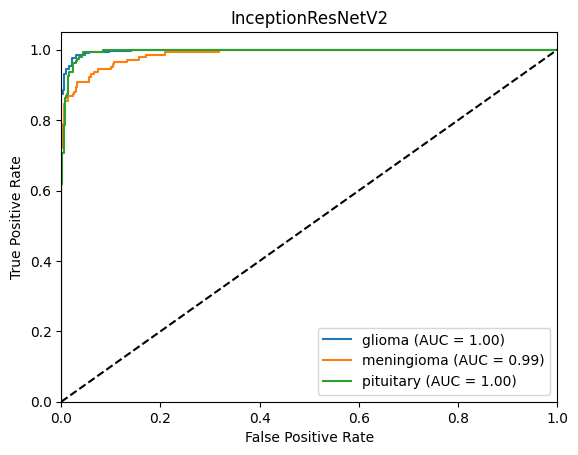

In [ ]:
evaluate_model(InceptionResnet_model, 'InceptionResNetV2')

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Confusion Matrix:
 [[ 9  0  0]
 [ 0  6  0]
 [ 0  0 17]] 

Accuracy: 1.0
Overall Precision: 1.0
Overall Recall: 1.0
Overall f1_score: 1.0
Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      1.00      1.00         9
  meningioma       1.00      1.00      1.00         6
   pituitary       1.00      1.00      1.00        17

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



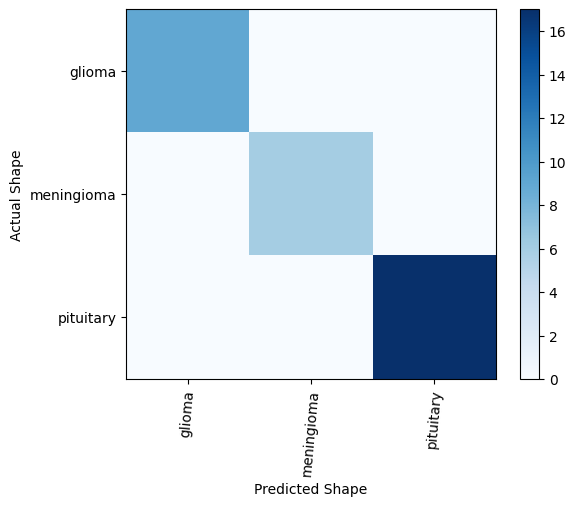

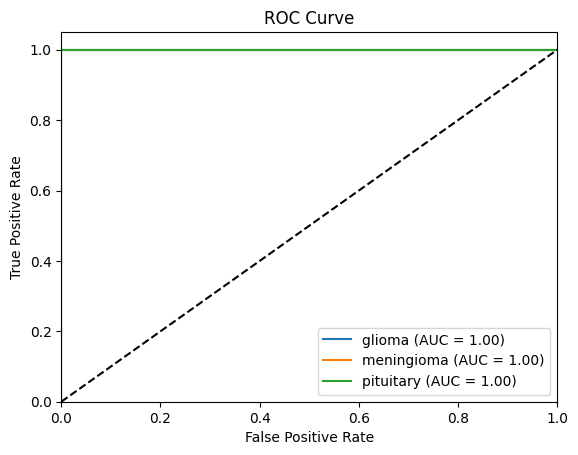

In [ ]:
# the previous result on 32 images

evaluate_model(InceptionResNetV2_model)

# **EfficientNetV2L Architecture**

In [ ]:
from tensorflow.keras.applications  import EfficientNetV2L
# Specify unique path for EfficientNetV2 model
efficientnetv2_model_path = '/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/EfficientNetV2.keras'

# Train EfficientNetV2 model
efficientnetv2_model, efficientnetv2_history = train(train_generator, val_generator, efficientnetv2_model_path,EfficientNetV2L)


473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5974 - loss: 0.8326 
Epoch 1: val_accuracy improved from -inf to 0.77467, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/EfficientNetV2.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1631s 21s/step - accuracy: 0.6000 - loss: 0.8286 - val_accuracy: 0.7747 - val_loss: 0.6052 - learning_rate: 1.0000e-04
Epoch 2/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 1:20 1s/step - accuracy: 0.9375 - loss: 0.2869

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.77467
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - accuracy: 0.9375 - loss: 0.2869 - val_accuracy: 0.7500 - val_loss: 0.9685 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9210 - loss: 0.2249
Epoch 3: val_accuracy improved from 0.77467 to 0.94243, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/EfficientNetV2.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.9210 - loss: 0.2246 - val_accuracy: 0.9424 - val_loss: 0.1876 - learning_rate: 1.0000e-04
Epoch 4/30
 1/57 ━━━━━━━━━━━━━━━━━━━━ 1:21 1s/step - accuracy: 1.0000 - loss: 0.0625
Epoch 4: val_accuracy improved from 0.94243 to 1.00000, saving model to /content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/EfficientNetV2.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 1.0000 - loss: 0.0625 - val_accuracy: 1.0000 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 5/30
57/57 ━━━━━━━━━

## **training and validation accuracy and loss**

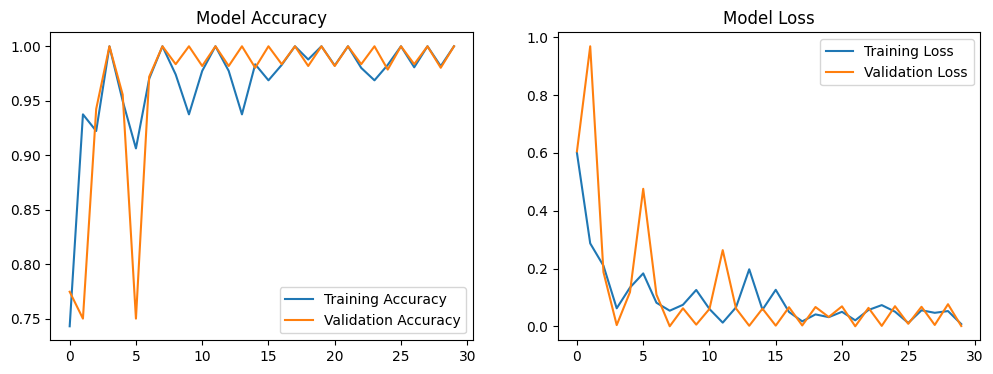

In [ ]:
plot_history(efficientnetv2_history)

In [ ]:
Efficientnet_model = load_model('/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/EfficientNetV2.keras')

test_loss5, test_accuracy5 = Efficientnet_model.evaluate(test_generator)
print("EfficientNetV2L /n Test Loss:", test_loss5)
print("Test Accuracy:", test_accuracy5)

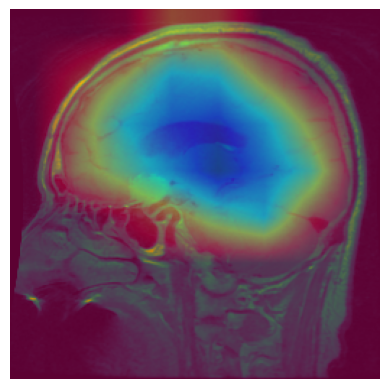

In [ ]:
# Generate Grad-CAM for ResNet50 with specific layer
heatmap = get_gradcam_heatmap(efficientnetv2_model, img_array, layer_name='top_conv')
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


## **Evaluation Metrics**

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 612ms/step
Confusion Matrix:
 [[273  10   3]
 [  4 129  10]
 [  2   3 186]] 

Accuracy: 0.9483870967741935
Overall Precision: 0.9405395649051457
Overall Recall: 0.9434884487240508
Overall f1_score: 0.9418269977189401
Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.95      0.97       286
  meningioma       0.91      0.90      0.91       143
   pituitary       0.93      0.97      0.95       191

    accuracy                           0.95       620
   macro avg       0.94      0.94      0.94       620
weighted avg       0.95      0.95      0.95       620



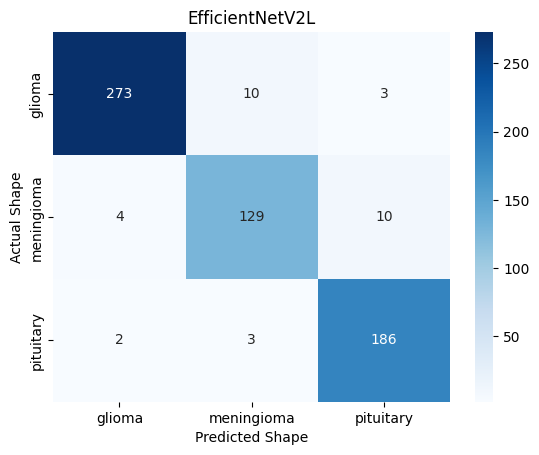

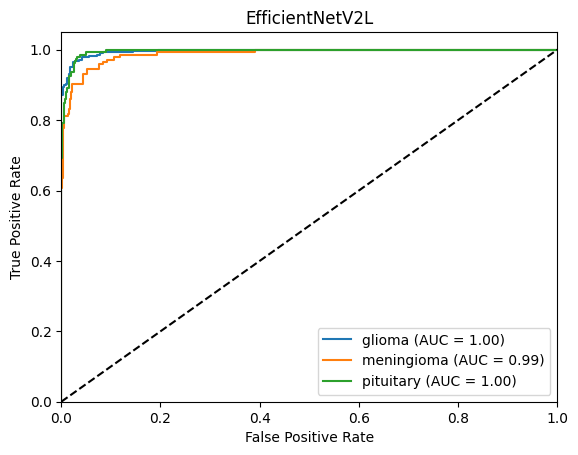

In [ ]:
evaluate_model(Efficientnet_model, 'EfficientNetV2L')

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
Confusion Matrix:
 [[14  0  0]
 [ 0  9  0]
 [ 0  0  9]] 

Accuracy: 1.0
Overall Precision: 1.0
Overall Recall: 1.0
Overall f1_score: 1.0
Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      1.00      1.00        14
  meningioma       1.00      1.00      1.00         9
   pituitary       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



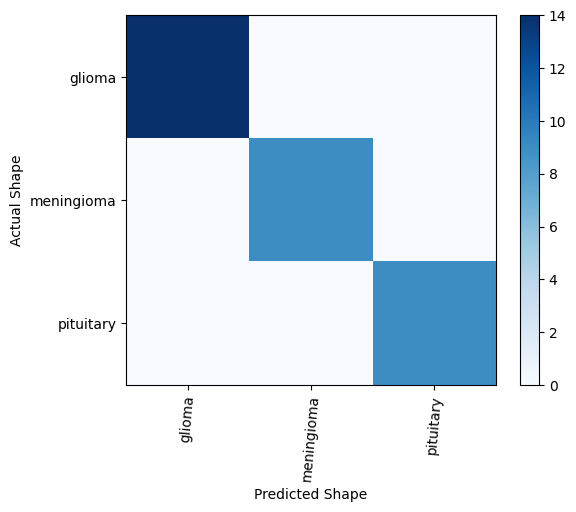

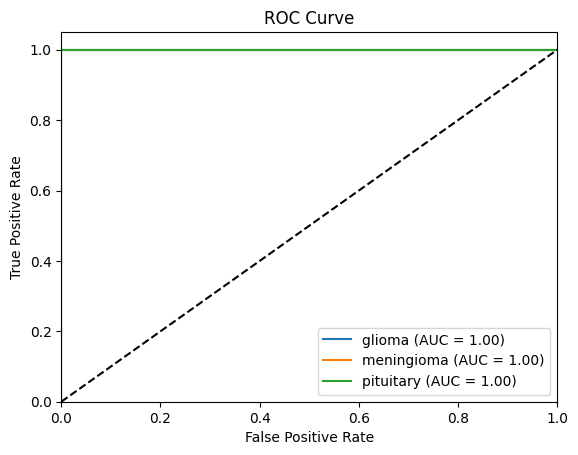

In [ ]:
# previous result on 32 images

evaluate_model(efficientnetv2_model)

# **Previous Evaluation Metrics**


Evaluating InceptionV3...
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
Accuracy for InceptionV3: 0.3597

Classification Report:
              precision    recall  f1-score   support

      glioma       0.46      0.47      0.47       286
  meningioma       0.20      0.18      0.19       143
   pituitary       0.31      0.32      0.32       191

    accuracy                           0.36       620
   macro avg       0.33      0.33      0.33       620
weighted avg       0.36      0.36      0.36       620


Confusion Matrix:
[[135  65  86]
 [ 65  26  52]
 [ 93  36  62]]


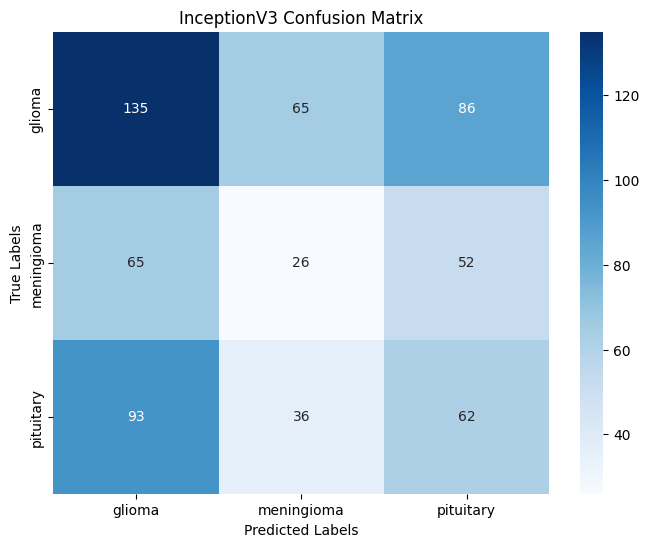

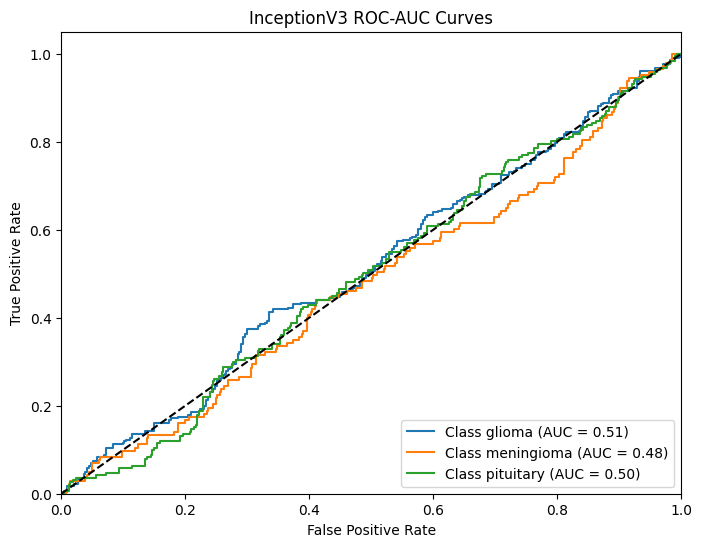

Macro AUC for InceptionV3: 0.4957
Micro AUC for InceptionV3: 0.5238

Evaluating ResNet50...
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 940ms/step
Accuracy for ResNet50: 0.3194

Classification Report:
              precision    recall  f1-score   support

      glioma       0.48      0.32      0.39       286
  meningioma       0.24      0.53      0.33       143
   pituitary       0.27      0.16      0.20       191

    accuracy                           0.32       620
   macro avg       0.33      0.34      0.30       620
weighted avg       0.36      0.32      0.32       620


Confusion Matrix:
[[ 92 140  54]
 [ 38  76  29]
 [ 61 100  30]]


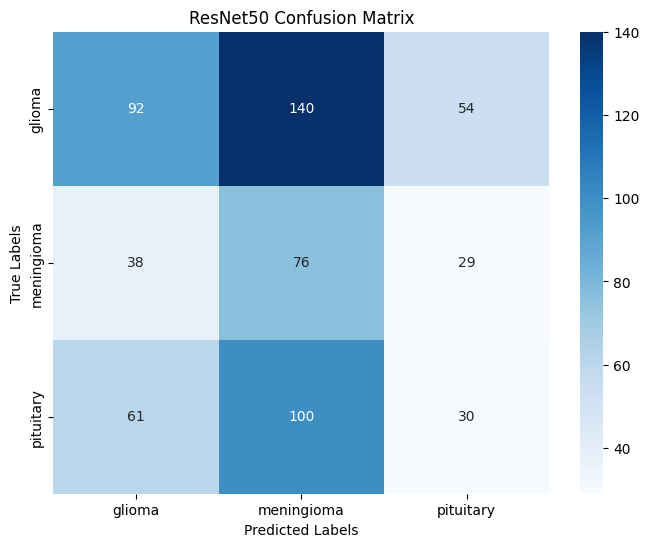

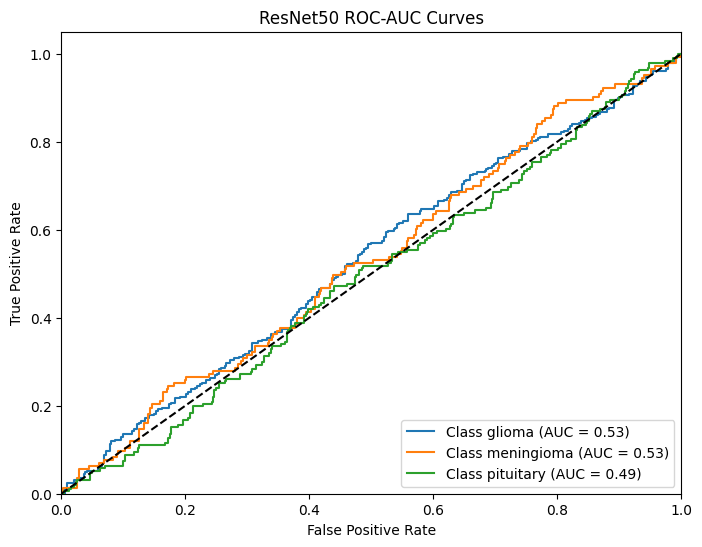

Macro AUC for ResNet50: 0.5164
Micro AUC for ResNet50: 0.5101

Evaluating EfficientNetB0...
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
Accuracy for EfficientNetB0: 0.3081

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       286
  meningioma       0.00      0.00      0.00       143
   pituitary       0.31      1.00      0.47       191

    accuracy                           0.31       620
   macro avg       0.10      0.33      0.16       620
weighted avg       0.09      0.31      0.15       620


Confusion Matrix:
[[  0   0 286]
 [  0   0 143]
 [  0   0 191]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

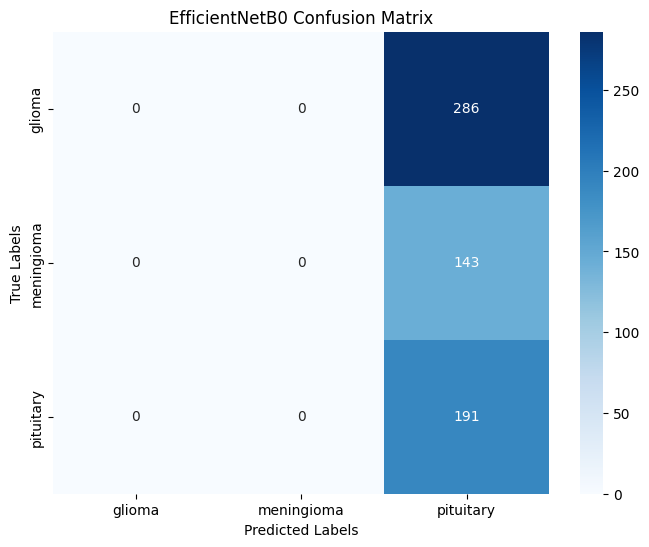

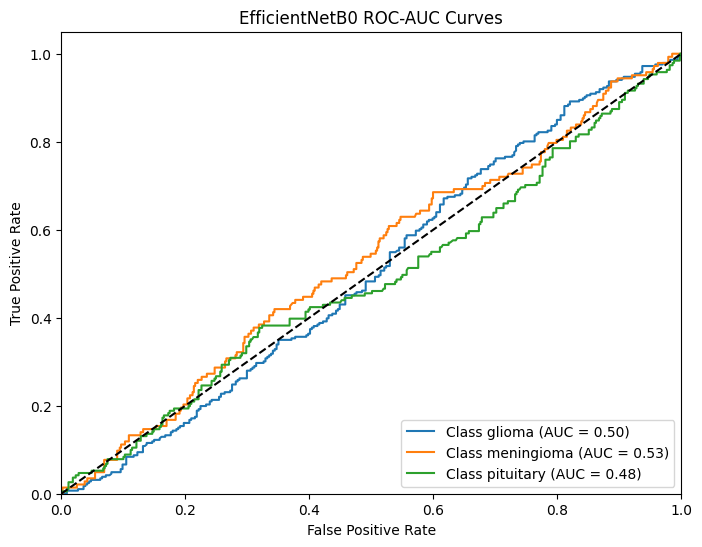

Macro AUC for EfficientNetB0: 0.5053
Micro AUC for EfficientNetB0: 0.5400

Evaluating EfficientNetV2...
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
Accuracy for EfficientNetV2: 0.4613

Classification Report:
              precision    recall  f1-score   support

      glioma       0.46      1.00      0.63       286
  meningioma       0.00      0.00      0.00       143
   pituitary       0.00      0.00      0.00       191

    accuracy                           0.46       620
   macro avg       0.15      0.33      0.21       620
weighted avg       0.21      0.46      0.29       620


Confusion Matrix:
[[286   0   0]
 [143   0   0]
 [191   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

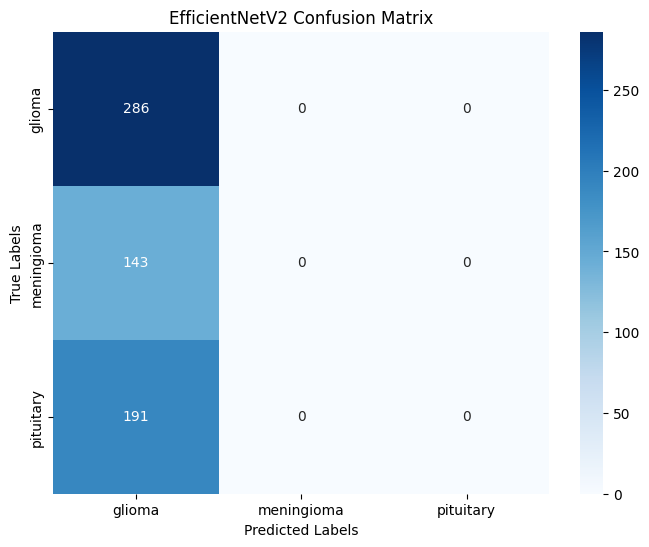

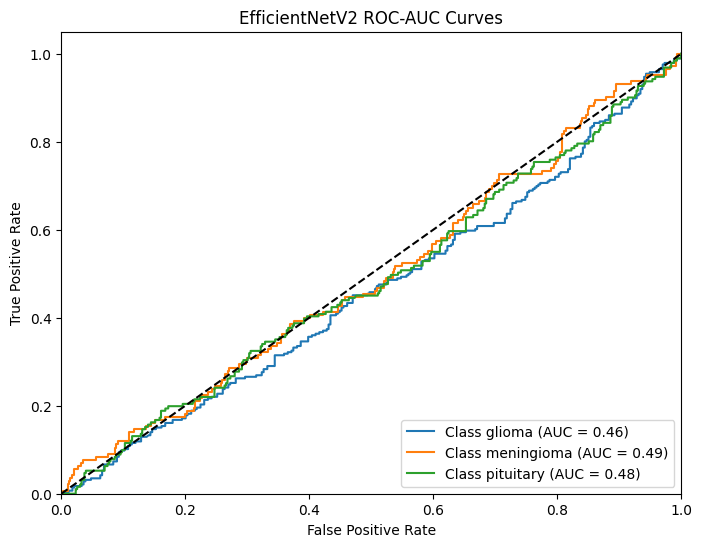

Macro AUC for EfficientNetV2: 0.4793
Micro AUC for EfficientNetV2: 0.6081

Evaluating VGG16...
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 765ms/step
Accuracy for VGG16: 0.3919

Classification Report:
              precision    recall  f1-score   support

      glioma       0.48      0.53      0.50       286
  meningioma       0.24      0.19      0.21       143
   pituitary       0.34      0.34      0.34       191

    accuracy                           0.39       620
   macro avg       0.35      0.35      0.35       620
weighted avg       0.38      0.39      0.38       620


Confusion Matrix:
[[151  53  82]
 [ 73  27  43]
 [ 93  33  65]]


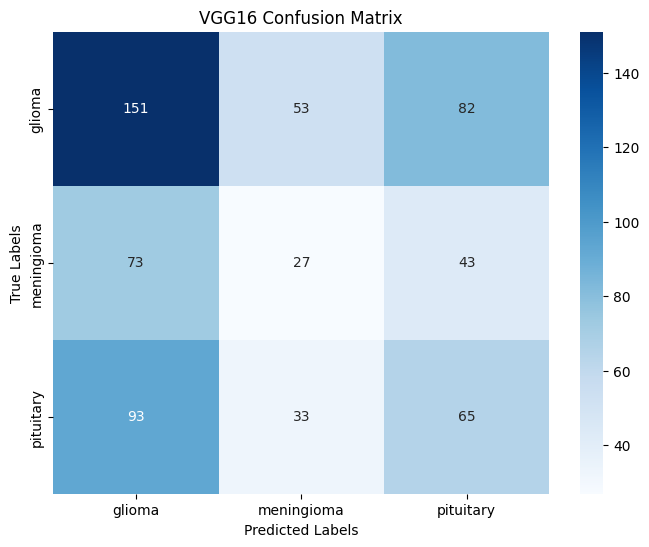

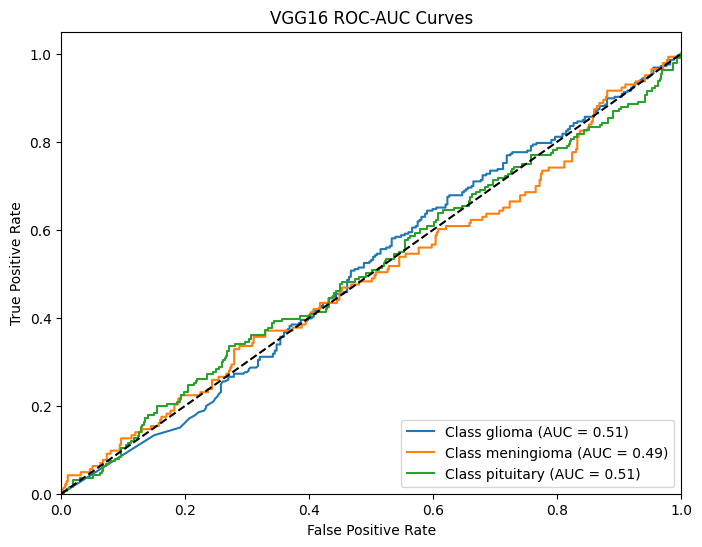

Macro AUC for VGG16: 0.5025
Micro AUC for VGG16: 0.5552

Evaluating DenseNet121...
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step
Accuracy for DenseNet121: 0.3419

Classification Report:
              precision    recall  f1-score   support

      glioma       0.44      0.45      0.45       286
  meningioma       0.19      0.20      0.19       143
   pituitary       0.31      0.29      0.30       191

    accuracy                           0.34       620
   macro avg       0.31      0.31      0.31       620
weighted avg       0.34      0.34      0.34       620


Confusion Matrix:
[[129  72  85]
 [ 75  28  40]
 [ 87  49  55]]


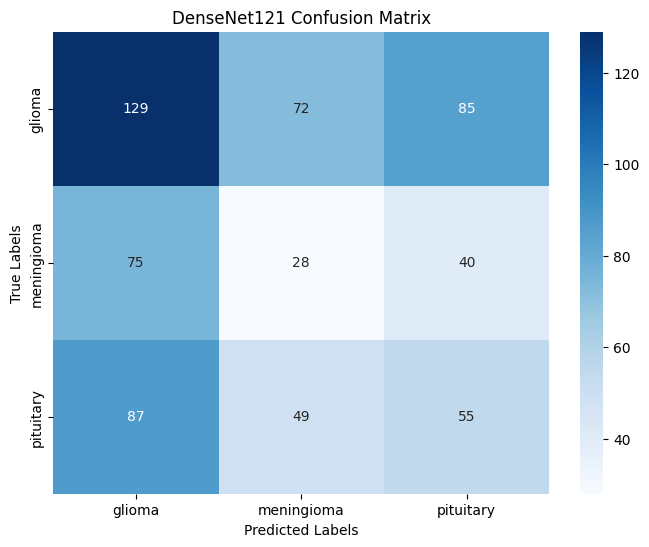

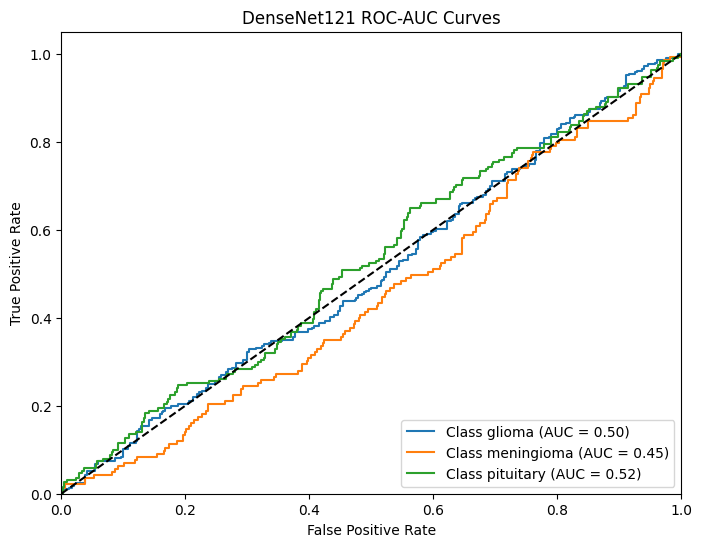

Macro AUC for DenseNet121: 0.4914
Micro AUC for DenseNet121: 0.5299

Evaluating MobileNetV2...
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 872ms/step
Accuracy for MobileNetV2: 0.4355

Classification Report:
              precision    recall  f1-score   support

      glioma       0.46      0.90      0.61       286
  meningioma       0.22      0.08      0.11       143
   pituitary       0.20      0.01      0.01       191

    accuracy                           0.44       620
   macro avg       0.29      0.33      0.24       620
weighted avg       0.32      0.44      0.31       620


Confusion Matrix:
[[258  25   3]
 [131  11   1]
 [176  14   1]]


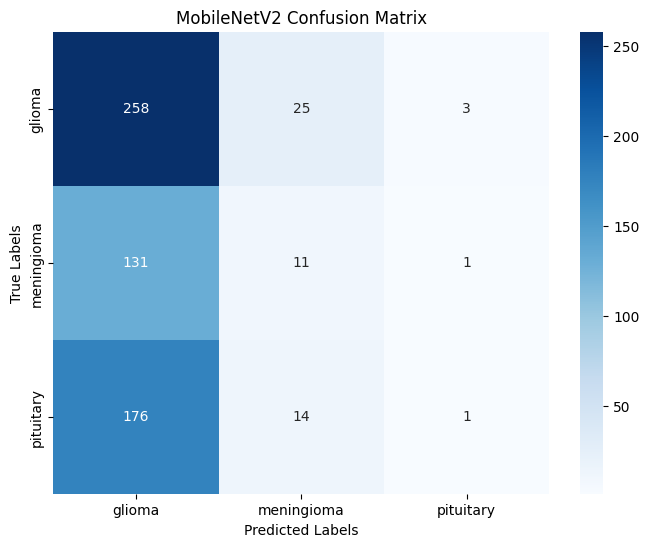

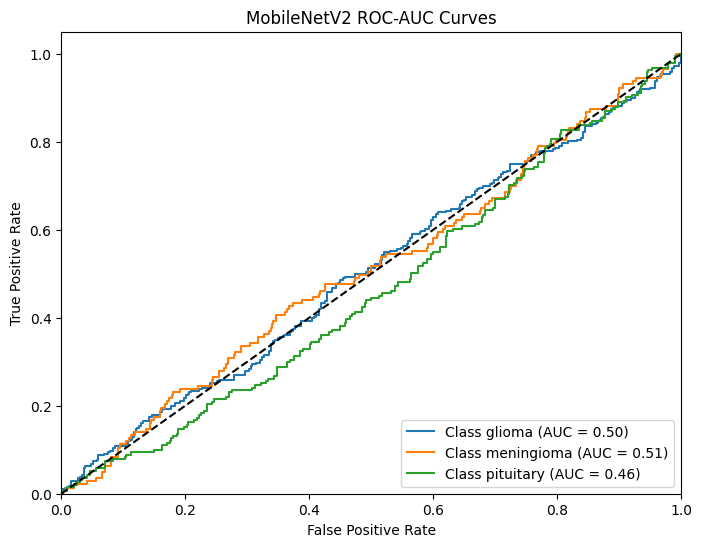

Macro AUC for MobileNetV2: 0.4917
Micro AUC for MobileNetV2: 0.5730


In [ ]:




# Define paths for the saved model files
model_paths = {
    "InceptionV3": "/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/New_INCEPTION_model.keras",
    "ResNet50": "/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewRESNET50.keras",
    "EfficientNetB0": "/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewEfficientNetB0.keras",
    "EfficientNetV2": "/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewEfficientNetV2.keras",
    "VGG16": "/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewVGG16.keras",
    "DenseNet121": "/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewDenseNet121.keras",
    "MobileNetV2": "/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewMobileNetV2.keras"
}

# List to hold evaluation results
evaluation_results = {}

# Loop over each model to evaluate it
for model_name, model_path in model_paths.items():
    print(f"\nEvaluating {model_name}...")

    # Load the model
    model = load_model(model_path)

    # Predict the classes of the test set
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys(), output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Store results in the dictionary
    evaluation_results[model_name] = {
        "accuracy": accuracy,
        "classification_report": class_report,
        "confusion_matrix": conf_matrix
    }

    # Print basic results
    print(f"Accuracy for {model_name}: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Binarize the true labels for ROC-AUC calculation
    y_true_binarized = label_binarize(y_true, classes=list(range(len(test_generator.class_indices))))

    # Compute ROC curve and ROC-AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(test_generator.class_indices)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC-AUC for each class
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(test_generator.class_indices.keys()):
        plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} ROC-AUC Curves")
    plt.legend(loc="lower right")
    plt.show()

    # Calculate and print macro and micro averaged AUC
    macro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, average="macro")
    micro_roc_auc = roc_auc_score(y_true_binarized, y_pred_probs, average="micro")
    print(f"Macro AUC for {model_name}: {macro_roc_auc:.4f}")
    print(f"Micro AUC for {model_name}: {micro_roc_auc:.4f}")

    # Store ROC-AUC metrics in evaluation_results
    evaluation_results[model_name]["roc_auc"] = {
        "per_class_auc": roc_auc,
        "macro_auc": macro_roc_auc,
        "micro_auc": micro_roc_auc
    }


In [ ]:
from keras.models import load_model

INC_Model = load_model("/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/New_INCEPTION_model.keras")
RES_Model = load_model("/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewRESNET50.keras")

VGG_Model = load_model("/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewVGG16.keras")
DenseNet121_Model = load_model("/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewDenseNet121.keras")
efficientnet_B0_Model = load_model("/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewEfficientNetB0.keras")
MobileNetV2_Model = load_model("/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewMobileNetV2.keras")
efficientnet_v2_Model = load_model("/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/NewEfficientNetV2.keras")

In [ ]:

# Evaluate model on test data
test_loss1, test_accuracy1 = INC_Model.evaluate(test_generator)
test_loss2, test_accuracy2 = RES_Model.evaluate(test_generator)
test_loss3, test_accuracy3 = VGG_Model.evaluate(test_generator)
test_loss4, test_accuracy4 = DenseNet121_Model.evaluate(test_generator)
test_loss5, test_accuracy5 = efficientnet_B0_Model.evaluate(test_generator)
test_loss6, test_accuracy6 = efficientnet_v2_Model.evaluate(test_generator)
test_loss7, test_accuracy7 = MobileNetV2_Model.evaluate(test_generator)

print("Inception /n Test Loss:", test_loss1)
print("Test Accuracy:", test_accuracy1)

print("ResNet50 /n Test Loss:", test_loss2)
print("Test Accuracy:", test_accuracy2)


print(" VGG16 /n Test Loss:", test_loss3)
print("Test Accuracy:", test_accuracy3)

print("DenseNet121 /n Test Loss:", test_loss4)
print("Test Accuracy:", test_accuracy4)

print("effiecient_B0 /n Test Loss:", test_loss5)
print("Test Accuracy:", test_accuracy5)

print("effiecient_v2 /n Test Loss:", test_loss6)
print("Test Accuracy:", test_accuracy6)

print("MobileNetV2 /n Test Loss:", test_loss7)
print("Test Accuracy:", test_accuracy7)


20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 893ms/step - accuracy: 0.9006 - loss: 0.2605
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 963ms/step - accuracy: 0.6208 - loss: 0.7750
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9300 - loss: 0.2157
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8496 - loss: 0.3572
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3407 - loss: 1.1144
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4457 - loss: 1.0699
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 842ms/step - accuracy: 0.5112 - loss: 1.5138
Inception /n Test Loss: 0.28678470849990845
Test Accuracy: 0.8838709592819214
ResNet50 /n Test Loss: 0.7762166857719421
Test Accuracy: 0.6193548440933228
 VGG16 /n Test Loss: 0.2102430760860443
Test Accuracy: 0.9290322661399841
DenseNet121 /n Test Loss: 0.36972805857658386
Test Accuracy: 0.8500000238418579
effiecient_B0 /n Test Loss: 1.1295299530029297
Test Accuracy: 0.3080645203590393
effiecient_v2 /n Test Loss: 1.06102454662323
Test Accuracy: 0.4612903296947479
MobileNetV2 

Found 620 images belonging to 3 classes.
Generating predictions from validation data...


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step


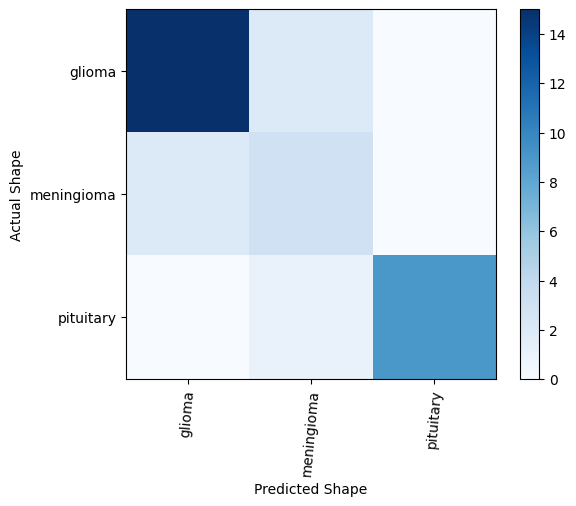

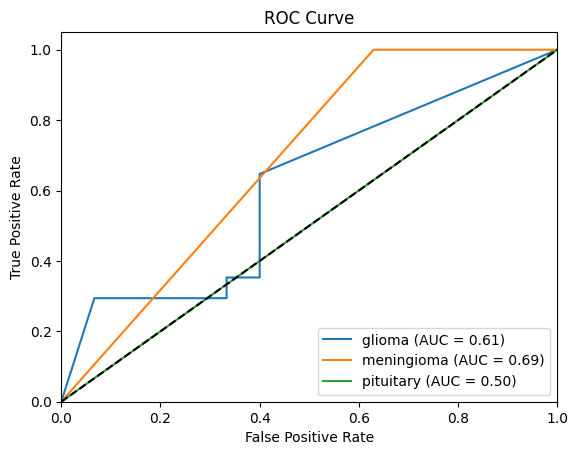

In [ ]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix,roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

datagen = ImageDataGenerator(featurewise_center = True, rotation_range=0.4,
                                  width_shift_range=0.3,
                                  horizontal_flip=True,
                                  zoom_range=0.4,
                                  shear_range = 0.4)

test_data4 = datagen.flow_from_directory(directory='/content/drive/MyDrive/Brain_tumor_classification/Brain_tumor_Data/test',
                                              target_size=(256,256),
                                              batch_size=32)

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = test_data4[0][0]
y_test = test_data4[0][1]

# Use the model to predict the class
class_probabilities1 = INC_Model.predict(x_test)
class_probabilities2 = RES_Model.predict(x_test)
class_probabilities3 = VGG_Model.predict(x_test)
class_probabilities4 = Inception_Res_v2_Model.predict(x_test)
class_probabilities5 = efficientnet_v2_Model.predict(x_test)


# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions1 = np.argmax(class_probabilities1, axis=1)
predictions2 = np.argmax(class_probabilities2, axis=1)
predictions3 = np.argmax(class_probabilities3, axis=1)
predictions4 = np.argmax(class_probabilities4, axis=1)
predictions5 = np.argmax(class_probabilities5, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm1 = confusion_matrix(true_labels, predictions1)
cm2 = confusion_matrix(true_labels, predictions2)
cm3 = confusion_matrix(true_labels, predictions3)
cm4 = confusion_matrix(true_labels, predictions4)
cm5 = confusion_matrix(true_labels, predictions5)

plt.imshow(cm1, interpolation="nearest", cmap=plt.cm.Blues)
plt.imshow(cm2, interpolation="nearest", cmap=plt.cm.Blues)
plt.imshow(cm3, interpolation="nearest", cmap=plt.cm.Blues)
plt.imshow(cm4, interpolation="nearest", cmap=plt.cm.Blues)
plt.imshow(cm5, interpolation="nearest", cmap=plt.cm.Blues)

plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels, class_probabilities1[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='{0} (AUC = {1:.2f})'.format(['glioma', 'meningioma', 'pituitary'][i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,auc,precision_score, recall_score,accuracy_score,f1_score
cm_list = [cm1, cm2, cm3, cm4, cm5]
classnames = ['glioma', 'meningioma', 'pituitary']
class_probabilities = [class_probabilities1,class_probabilities2,class_probabilities3,class_probabilities4,class_probabilities5]

def plot_evaluation(cm,cp,predictions):
    print('Confusion Matrix:\n',cm, '\n')
    print('Accuracy:', accuracy_score(true_labels, predictions))
    print("Overall Precision:",precision_score(true_labels, predictions,  average='macro'))
    print("Overall Recall:",recall_score(true_labels, predictions, average='macro'))
    print("Overall f1_score:",f1_score(true_labels, predictions, average='macro'))

    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)

    plt.colorbar()
    tick_marks = np.arange(len(classnames))
    plt.xticks(tick_marks, classnames, rotation=85)
    plt.yticks(tick_marks, classnames)
    plt.xlabel("Predicted Shape")
    plt.ylabel("Actual Shape")
    plt.show()


    # Plot ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):

        fpr[i], tpr[i], _ = roc_curve(true_labels, cp[:, i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(3):
        plt.plot(fpr[i], tpr[i], label='{0} (AUC = {1:.2f})'.format(['glioma', 'meningioma', 'pituitary'][i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.05)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

Confusion Matrix:
 [[ 5 12  0]
 [ 0  5  0]
 [ 1  9  0]] 

Accuracy: 0.3125
Overall Precision: 0.34188034188034194
Overall Recall: 0.43137254901960786
Overall f1_score: 0.25245441795231416


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


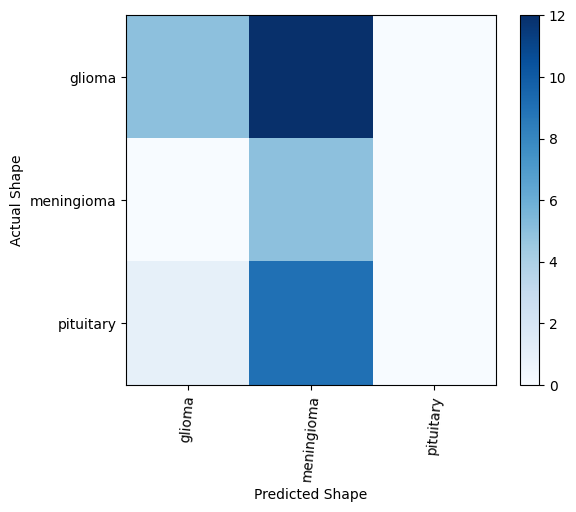

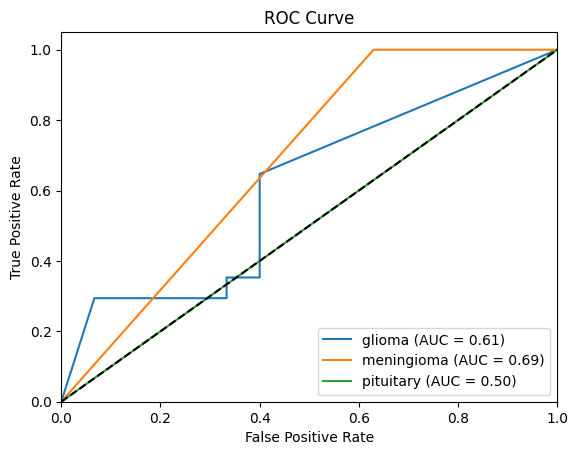

In [ ]:
plot_evaluation(cm1,class_probabilities1,predictions1)

Confusion Matrix:
 [[10  7  0]
 [ 0  4  1]
 [ 0  5  5]] 

Accuracy: 0.59375
Overall Precision: 0.6944444444444445
Overall Recall: 0.6294117647058823
Overall f1_score: 0.5822310405643739


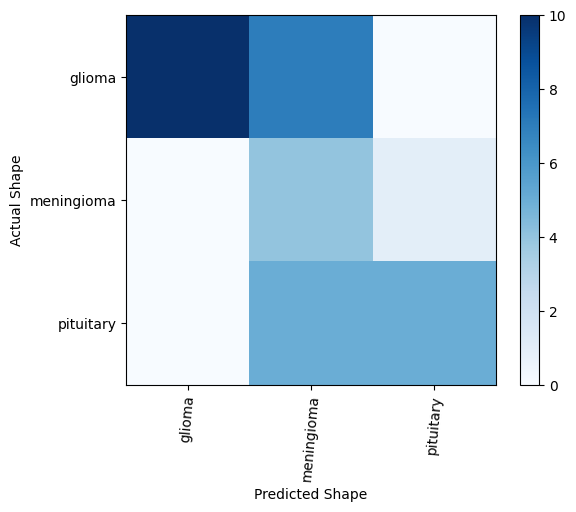

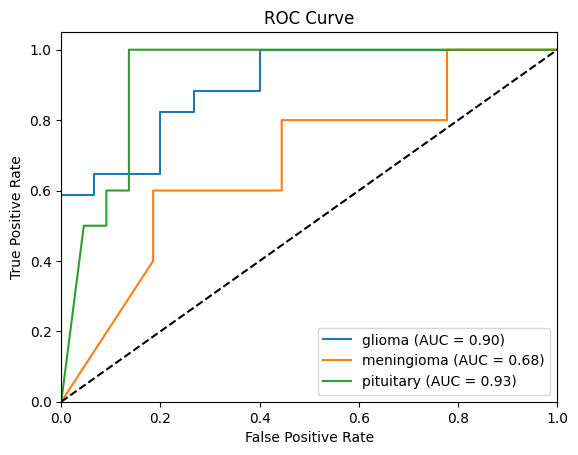

In [ ]:
plot_evaluation(cm2,class_probabilities2,predictions2)

Confusion Matrix:
 [[9 7 1]
 [1 4 0]
 [1 3 6]] 

Accuracy: 0.59375
Overall Precision: 0.6536796536796537
Overall Recall: 0.6431372549019608
Overall f1_score: 0.5899307091257556


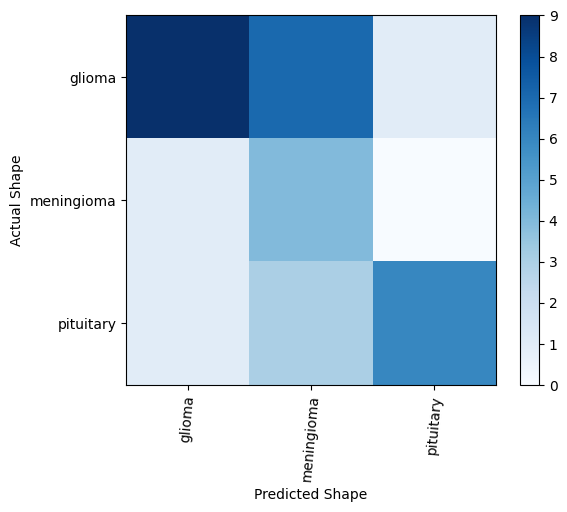

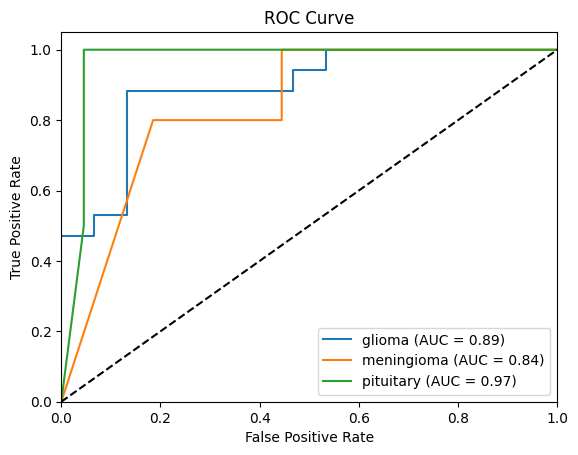

In [ ]:
plot_evaluation(cm3,class_probabilities3,predictions3)

Confusion Matrix:
 [[ 5 12  0]
 [ 0  5  0]
 [ 0 10  0]] 

Accuracy: 0.3125
Overall Precision: 0.3950617283950617
Overall Recall: 0.43137254901960786
Overall f1_score: 0.2556818181818182


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


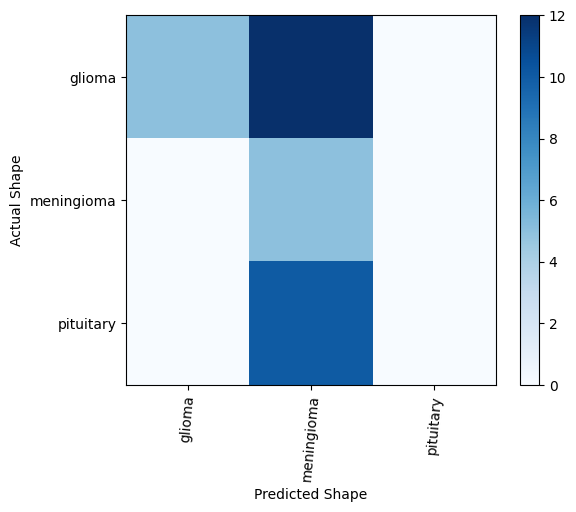

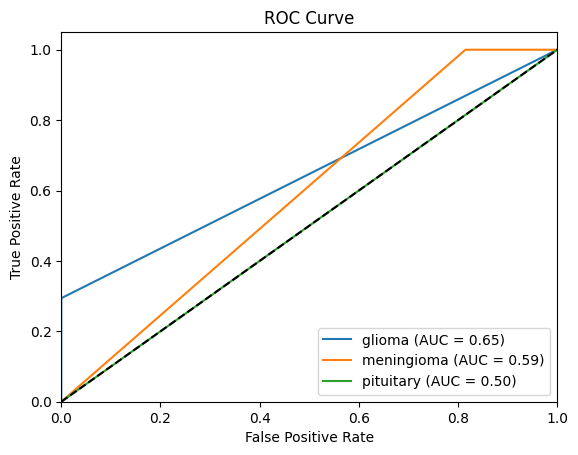

In [ ]:
plot_evaluation(cm4,class_probabilities4,predictions4)

Confusion Matrix:
 [[15  2  0]
 [ 2  3  0]
 [ 0  1  9]] 

Accuracy: 0.84375
Overall Precision: 0.7941176470588235
Overall Recall: 0.7941176470588235
Overall f1_score: 0.7917253025612158


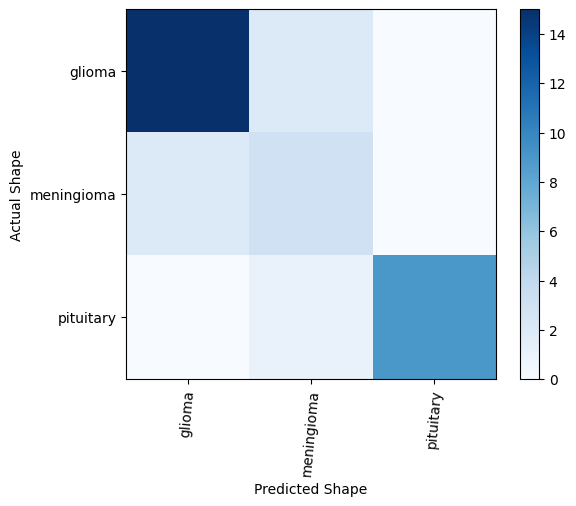

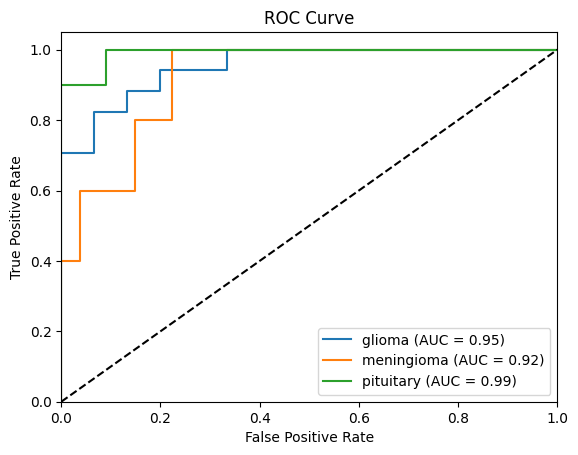

In [ ]:
plot_evaluation(cm5,class_probabilities5,predictions5)